In [1]:
!which python

/Users/aaron/Documents/github/ssd-pytorch/venv/bin/python


In [2]:
import enum
import math
import pdb
import platform
import time

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook

from ssdmultibox import utils
from ssdmultibox.bboxer import Bboxer, TensorBboxer
from ssdmultibox.config import cfg
from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, TrainPascalFlatDataset, device
from ssdmultibox.models import SSDModel
from ssdmultibox.plotting import *
from ssdmultibox.predict import Predict
from ssdmultibox.utils import open_image

import matplotlib.pyplot as plt
plt.ion()

In [3]:
device

device(type='cpu')

In [4]:
losses = {'total':[], 'loc':[], 'conf':[]}

In [5]:
model = SSDModel().to(device)

In [6]:
LR = 1e-2

criterion = SSDLoss(alpha=.2)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
current_time = time.time()

In [7]:
TrainPascalFlatDataset.__len__ = lambda self: 4

train_dataset = TrainPascalFlatDataset()

len(train_dataset)

4

In [8]:
train_dataset

In [9]:
NUM_WORKERS = utils.get_cpu_count()

# if platform.system() == 'Darwin': # Mac
#     BATCH = 4
#     SHUFFLE = False
# else:
#     BATCH = 32
#     SHUFFLE = True

BATCH = 4
SHUFFLE = False
    
dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUM_WORKERS)

vars(dataloader)

{'dataset': <ssdmultibox.datasets.TrainPascalFlatDataset at 0x13b07b550>,
 'batch_size': 4,
 'num_workers': 4,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.SequentialSampler at 0x13b07be48>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x13b07be80>,
 '_DataLoader__initialized': True}

In [10]:
EPOCHS = 1

for epoch in range(EPOCHS):
    steps = math.ceil(len(train_dataset) / BATCH)
    for step in tqdm_notebook(range(steps)):
        image_ids, ims, gt_bbs, gt_cats = next(iter(dataloader))

        # put data on device
        ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        preds = model(ims)
        loss, loc_loss, conf_loss = criterion(preds, (gt_bbs, gt_cats))

        # backward pass
        loss.backward()
        optimizer.step()

        # stats
        if step % 5 == 0:
            print('epoch: {} step: {} loss: {:.4f} time: {:.4f}'.format(
                epoch, step, loss.item(), time.time() - current_time))
            current_time = time.time()
            losses['total'].append(loss.item())
            losses['loc'].append(loc_loss.item())
            losses['conf'].append(conf_loss.item())

pos_loss: 112.5088 neg_hard_mining_loss: 354.9200
n: 37.0 bbs_loss: 542.4760 cats_loss: 467.4289
epoch: 0 step: 0 loss: 27.2947 time: 10.3900



In [11]:
bbs_preds, cats_preds = preds

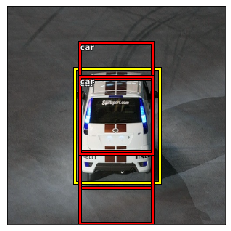

In [12]:
idx = 0
dataset = train_dataset

plot_anchor_bbs(dataset, image_ids, idx, gt_cats)

In [ ]:
plot_preds(dataset, image_ids, idx, bbs_preds, gt_cats)

## plotting - add category labels

In [26]:
import cv2
import numpy as np
import torch
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt

from ssdmultibox.bboxer import Bboxer, TensorBboxer
from ssdmultibox.config import cfg
from ssdmultibox.predict import Predict
from ssdmultibox.utils import open_image

def get_targets(gt_cats, idx, bbs_preds=None):
    gt_cat = torch.tensor(gt_cats[idx])
    not_bg_mask = gt_cat != 20
    not_bg_mask = (not_bg_mask == 1).nonzero()
    not_bg_mask = not_bg_mask.squeeze(1)
    stacked_anchor_boxes = TensorBboxer.get_stacked_anchor_boxes()
    bbs = stacked_anchor_boxes[not_bg_mask]
    if isinstance(bbs_preds, torch.Tensor):
        bbs = bbs_preds[idx][not_bg_mask]
    cats = gt_cats[idx][not_bg_mask]
    return bbs, cats

idx = 0
dataset = train_dataset

bbs_cats_targets = get_targets(gt_cats, idx)
bbs_cats_targets

(tensor([[0.3333, 0.3333, 0.6667, 0.6667],
         [0.1667, 0.3333, 0.8333, 0.6667],
         [0.3333, 0.3333, 1.0000, 0.6667],
         [0.3243, 0.3333, 0.6757, 0.6667]]), tensor([6, 6, 6, 6]))

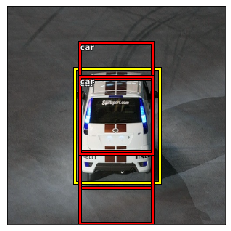

In [40]:
def plot_single_predictions(dataset, idx, targets):
    """
    Plots the gt bb(s) and predicted bbs

    Args:
        dataset (torch.utils.data.Dataset)
        idx (int): index of dataset item to show
        targets (2d array):
            fastai formatted bbs to plot, [0,1] normalized
    """
    image_id, im, gt_bbs, gt_cats = dataset[idx]
    ann = dataset.get_annotations()[image_id]
    im = open_image(ann['image_path'])
    resized_im = cv2.resize(im, (cfg.SIZE, cfg.SIZE))
    ax = show_img(resized_im)

    for gt_bb in (Bboxer.scaled_pascal_bbs(np.array(ann['bbs']), im) * cfg.SIZE):
        draw_rect(ax, gt_bb, edgecolor='yellow')

    cat_names = dataset.categories()
    for i, (bb,cat) in enumerate(zip(*targets)):
        pascal_bb = Bboxer.fastai_bb_to_pascal_bb(bb)*cfg.SIZE
        draw_rect(ax, pascal_bb, edgecolor='red')
        draw_text(ax, pascal_bb[:2], cat_names[cat.item()], sz=8)
        
plot_single_predictions(dataset, idx, bbs_cats_targets)

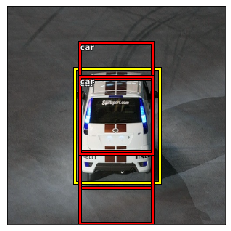

In [42]:
def plot_anchor_bbs(dataset, image_ids, idx, gt_cats):
    "Plots the ground truth anchor boxes"
    image_id = image_ids[idx].item()
    dataset_idx = dataset.get_image_id_idx_map()[image_id]
    plot_single_predictions(
        dataset, dataset_idx,
        targets=get_targets(gt_cats, idx))
plot_anchor_bbs(dataset, image_ids, idx, gt_cats)

In [38]:
def plot_preds(dataset, image_ids, idx, bbs_preds, gt_cats):
    "Plots the predictions based on the ground truth anchor box offsets"
    image_id = image_ids[idx].item()
    dataset_idx = dataset.get_image_id_idx_map()[image_id]
    plot_single_predictions(
        dataset, dataset_idx,
        targets=get_targets(gt_cats, idx, bbs_preds))
plot_preds(dataset, image_ids, idx, bbs_preds, gt_cats)

## check new tanh normalized preds

In [12]:
mask = gt_cats != 20

In [16]:
bbs_preds[mask][:4], gt_bbs[mask][:4], F.smooth_l1_loss(bbs_preds[mask][:4], gt_bbs[mask][:4])

(tensor([[ 99.6802,  99.3283, 200.4254, 199.9810],
         [ 49.3467,  99.5358, 250.4985, 199.8989],
         [100.0716, 100.4395, 300.0000, 200.6363],
         [ 97.6072,  99.5989, 201.8856, 199.2377]], grad_fn=<SliceBackward>),
 tensor([[ 86.4865,  93.0000, 242.2432, 209.6000],
         [ 86.4865,  93.0000, 242.2432, 209.6000],
         [ 86.4865,  93.0000, 242.2432, 209.6000],
         [ 86.4865,  93.0000, 242.2432, 209.6000]]),
 tensor(17.5485, grad_fn=<SmoothL1LossBackward>))

In [18]:
bbs_preds[0][:4]

tensor([[ 0.0000,  0.0403,  7.8010,  7.9052],
        [ 0.0914,  8.0735,  7.9015, 15.7416],
        [ 0.0313, 15.9205,  7.8671, 23.6791],
        [ 0.0854, 23.7860,  7.8897, 31.5926]], grad_fn=<SliceBackward>)

In [20]:
TensorBboxer.get_stacked_anchor_boxes()[:4] * cfg.SIZE

tensor([[ 0.0000,  0.0000,  7.8947,  7.8947],
        [ 0.0000,  7.8947,  7.8947, 15.7895],
        [ 0.0000, 15.7895,  7.8947, 23.6842],
        [ 0.0000, 23.6842,  7.8947, 31.5789]])

## tanh for feature map cell size

In [79]:
cell_size = 2
normalized_size = 1

allowed_offset = (normalized_size/cell_size) / 4
allowed_offset

0.125

In [88]:
cfg.ALLOWED_OFFSET = .25

def get_allowed_offset(cell_size):
    normalized_size = 1
    return (normalized_size/cell_size) * cfg.ALLOWED_OFFSET
    
get_allowed_offset(2)

0.125

In [86]:
get_allowed_offset(1)

0.25

In [87]:
get_allowed_offset(3)

0.08333333333333333

In [24]:
gt_bbs.shape, bbs_preds.shape

(torch.Size([4, 11640, 4]), torch.Size([4, 11640, 4]))

In [25]:
cfg.FEATURE_MAPS

[38, 19, 10, 5, 3, 1]

In [29]:
total = 0
for fm in cfg.FEATURE_MAPS:
    total += fm*fm*6
total

11640

In [30]:
torch.FloatTensor(2,1).fill_(38)

tensor([[38.],
        [38.]])

In [162]:
cfg.ASPECT_RATIOS = 6

fm_max_offsets =  torch.cat(
    [torch.FloatTensor(fm*fm*cfg.ASPECT_RATIOS,1).fill_(get_allowed_offset(fm))
     for fm in cfg.FEATURE_MAPS], dim=0)

(1/38)*.25, fm_max_offsets[:10], fm_max_offsets[-10:], fm_max_offsets.shape

(0.006578947368421052, tensor([[0.0066],
         [0.0066],
         [0.0066],
         [0.0066],
         [0.0066],
         [0.0066],
         [0.0066],
         [0.0066],
         [0.0066],
         [0.0066]]), tensor([[0.0833],
         [0.0833],
         [0.0833],
         [0.0833],
         [0.2500],
         [0.2500],
         [0.2500],
         [0.2500],
         [0.2500],
         [0.2500]]), torch.Size([11640, 1]))

In [100]:
bbs_offsets = gt_bbs - bbs_preds
bbs_offsets.shape

torch.Size([4, 11640, 4])

In [101]:
bbs_offsets[mask][:4]

tensor([[-15.5702,  -3.0814,  42.5275,   2.3098],
        [ 37.0137,  -8.5627,  -0.7539,  11.9434],
        [-14.9237,  -9.8804, -57.7568,  11.6067],
        [-11.2478,  -6.6931,  44.0195,   5.9905]], grad_fn=<SliceBackward>)

In [102]:
bbs_preds[mask][:4]

tensor([[102.0567,  96.0814, 199.7157, 207.2902],
        [ 49.4727, 101.5627, 242.9971, 197.6566],
        [101.4102, 102.8804, 300.0000, 197.9933],
        [ 97.7343,  99.6931, 198.2238, 203.6095]], grad_fn=<SliceBackward>)

In [105]:
gt_bbs[mask][:4]

tensor([[ 86.4865,  93.0000, 242.2432, 209.6000],
        [ 86.4865,  93.0000, 242.2432, 209.6000],
        [ 86.4865,  93.0000, 242.2432, 209.6000],
        [ 86.4865,  93.0000, 242.2432, 209.6000]])

In [111]:
bbs_preds_offsets = gt_bbs[mask][:4] - bbs_preds[mask][:4]
bbs_preds_offsets

tensor([[-15.5702,  -3.0814,  42.5275,   2.3098],
        [ 37.0137,  -8.5627,  -0.7539,  11.9434],
        [-14.9237,  -9.8804, -57.7568,  11.6067],
        [-11.2478,  -6.6931,  44.0195,   5.9905]], grad_fn=<ThSubBackward>)

In [113]:
scaled_bbs_preds_offsets = bbs_preds_offsets / cfg.SIZE
scaled_bbs_preds_offsets

tensor([[-0.0519, -0.0103,  0.1418,  0.0077],
        [ 0.1234, -0.0285, -0.0025,  0.0398],
        [-0.0497, -0.0329, -0.1925,  0.0387],
        [-0.0375, -0.0223,  0.1467,  0.0200]], grad_fn=<DivBackward0>)

In [115]:
torch.tanh(scaled_bbs_preds_offsets)

tensor([[-0.0519, -0.0103,  0.1408,  0.0077],
        [ 0.1228, -0.0285, -0.0025,  0.0398],
        [-0.0497, -0.0329, -0.1902,  0.0387],
        [-0.0375, -0.0223,  0.1457,  0.0200]], grad_fn=<TanhBackward>)

In [120]:
fm_max_offsets.shape

torch.Size([11640, 1])

In [121]:
fm_max_offsets[mask[0]]

tensor([[0.0833],
        [0.0833],
        [0.0833],
        [0.0833]])

In [145]:
scaled_max_offsets = torch.tanh(scaled_bbs_preds_offsets) * fm_max_offsets[mask[0]]
scaled_max_offsets

tensor([[-0.0043, -0.0009,  0.0117,  0.0006],
        [ 0.0102, -0.0024, -0.0002,  0.0033],
        [-0.0041, -0.0027, -0.0158,  0.0032],
        [-0.0031, -0.0019,  0.0121,  0.0017]], grad_fn=<ThMulBackward>)

In [146]:
bbs_preds[mask][:4]

tensor([[102.0567,  96.0814, 199.7157, 207.2902],
        [ 49.4727, 101.5627, 242.9971, 197.6566],
        [101.4102, 102.8804, 300.0000, 197.9933],
        [ 97.7343,  99.6931, 198.2238, 203.6095]], grad_fn=<SliceBackward>)

In [149]:
anchor_bbs = TensorBboxer.get_stacked_anchor_boxes()
bbs_anchor_bbs = anchor_bbs[mask[0]]
bbs_anchor_bbs

tensor([[0.3333, 0.3333, 0.6667, 0.6667],
        [0.1667, 0.3333, 0.8333, 0.6667],
        [0.3333, 0.3333, 1.0000, 0.6667],
        [0.3243, 0.3333, 0.6757, 0.6667]])

In [159]:
bbs_preds_w_max_offsets = (bbs_anchor_bbs + scaled_max_offsets) * cfg.SIZE
bbs_preds_w_max_offsets

tensor([[ 98.7036,  99.7432, 203.5204, 200.1925],
        [ 53.0689,  99.2866, 249.9372, 200.9948],
        [ 98.7574,  99.1769, 295.2455, 200.9668],
        [ 96.3585,  99.4423, 206.3468, 200.4991]], grad_fn=<MulBackward>)

In [151]:
gt_bbs[mask][:4]

tensor([[ 86.4865,  93.0000, 242.2432, 209.6000],
        [ 86.4865,  93.0000, 242.2432, 209.6000],
        [ 86.4865,  93.0000, 242.2432, 209.6000],
        [ 86.4865,  93.0000, 242.2432, 209.6000]])

In [153]:
bbs_preds_w_max_offsets - gt_bbs[mask][:4]

tensor([[ 12.2172,   6.7432, -38.7228,  -9.4075],
        [-33.4176,   6.2866,   7.6939,  -8.6052],
        [ 12.2709,   6.1769,  53.0023,  -8.6333],
        [  9.8720,   6.4423, -35.8964,  -9.1009]], grad_fn=<ThSubBackward>)

In [156]:
bbs_preds[mask][:4]

tensor([[102.0567,  96.0814, 199.7157, 207.2902],
        [ 49.4727, 101.5627, 242.9971, 197.6566],
        [101.4102, 102.8804, 300.0000, 197.9933],
        [ 97.7343,  99.6931, 198.2238, 203.6095]], grad_fn=<SliceBackward>)

In [158]:
# without tanh max offset scaling
F.smooth_l1_loss(bbs_preds[mask][:4], target=gt_bbs[mask][:4])

tensor(17.2445, grad_fn=<SmoothL1LossBackward>)

In [160]:
# with tanh max offset scaling
F.smooth_l1_loss(bbs_preds_w_max_offsets, target=gt_bbs[mask][:4])

tensor(16.0306, grad_fn=<SmoothL1LossBackward>)

In [174]:
def get_allowed_offset(cell_size):
    normalized_size = 1
    return (normalized_size/cell_size) * cfg.ALLOWED_OFFSET

fm_max_offsets =  torch.cat(
    [torch.FloatTensor(fm*fm*cfg.ASPECT_RATIOS,1).fill_(get_allowed_offset(fm))
     for fm in cfg.FEATURE_MAPS], dim=0)

torch.tanh(preds) * fm_max_offsets

TypeError: tanh(): argument 'input' (position 1) must be Tensor, not tuple

In [169]:
fm_max_offsets[0].item()

0.00657894741743803

In [165]:
(1/38)*.25

0.006578947368421052

In [173]:
def str_float(x):
    return "{:.8f}".format(x)

str_float(fm_max_offsets[0].item()) == str_float((1/38)*.25)

True

In [97]:
bbs_allowed_offsets = torch.tanh(bbs_offsets/cfg.SIZE) * fm_max_offsets
bbs_allowed_offsets.shape

torch.Size([4, 11640, 4])

In [98]:
bbs_allowed_offsets[mask][:4]

tensor([[-0.0043, -0.0009,  0.0117,  0.0006],
        [ 0.0102, -0.0024, -0.0002,  0.0033],
        [-0.0041, -0.0027, -0.0158,  0.0032],
        [-0.0031, -0.0019,  0.0121,  0.0017]], grad_fn=<SliceBackward>)

In [99]:
bbs_preds[mask][:4]

tensor([[102.0567,  96.0814, 199.7157, 207.2902],
        [ 49.4727, 101.5627, 242.9971, 197.6566],
        [101.4102, 102.8804, 300.0000, 197.9933],
        [ 97.7343,  99.6931, 198.2238, 203.6095]], grad_fn=<SliceBackward>)

In [108]:
bbs_offsets[mask][:4] / cfg.SIZE

tensor([[-0.0519, -0.0103,  0.1418,  0.0077],
        [ 0.1234, -0.0285, -0.0025,  0.0398],
        [-0.0497, -0.0329, -0.1925,  0.0387],
        [-0.0375, -0.0223,  0.1467,  0.0200]], grad_fn=<DivBackward0>)

In [107]:
unscaled_offsets / cfg.SIZE

tensor([[-0.0519, -0.0103,  0.1418,  0.0077],
        [ 0.1234, -0.0285, -0.0025,  0.0398],
        [-0.0497, -0.0329, -0.1925,  0.0387],
        [-0.0375, -0.0223,  0.1467,  0.0200]], grad_fn=<DivBackward0>)

In [64]:
gt_bbs[mask][:4]

tensor([[ 86.4865,  93.0000, 242.2432, 209.6000],
        [ 86.4865,  93.0000, 242.2432, 209.6000],
        [ 86.4865,  93.0000, 242.2432, 209.6000],
        [ 86.4865,  93.0000, 242.2432, 209.6000]])

In [66]:
combined = gt_bbs[mask][:4] + fm_sizes
combined

tensor([[ 87.4865,  94.0000, 243.2432, 210.6000],
        [ 87.4865,  94.0000, 243.2432, 210.6000],
        [ 88.4865,  95.0000, 244.2432, 211.6000],
        [ 88.4865,  95.0000, 244.2432, 211.6000]])

In [67]:
combined - gt_bbs[mask][:4]

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.]])

In [17]:
gt_bbs[0][-1]

tensor([ 86.4865,  93.0000, 242.2432, 209.6000])

In [18]:
bbs_preds[0][-1]

tensor([  2.8209,   0.0000, 300.0000, 300.0000], grad_fn=<SelectBackward>)

In [19]:
mask = gt_cats != 20

In [21]:
bbs_preds[mask][:4]

tensor([[102.0567,  96.0814, 199.7157, 207.2902],
        [ 49.4727, 101.5627, 242.9971, 197.6566],
        [101.4102, 102.8804, 300.0000, 197.9933],
        [ 97.7343,  99.6931, 198.2238, 203.6095]], grad_fn=<SliceBackward>)

In [22]:
gt_bbs[mask][:4]

tensor([[ 86.4865,  93.0000, 242.2432, 209.6000],
        [ 86.4865,  93.0000, 242.2432, 209.6000],
        [ 86.4865,  93.0000, 242.2432, 209.6000],
        [ 86.4865,  93.0000, 242.2432, 209.6000]])

## check using `mask`

In [12]:
mask = gt_cats != 20
mask.sum()

tensor(37)

In [13]:
gt_bbs[mask][:4], bbs_preds[mask][:4]

(tensor([[ 86.4865,  93.0000, 242.2432, 209.6000],
         [ 86.4865,  93.0000, 242.2432, 209.6000],
         [ 86.4865,  93.0000, 242.2432, 209.6000],
         [ 86.4865,  93.0000, 242.2432, 209.6000]]),
 tensor([[103.2652, 108.6540, 196.7100, 190.6101],
         [ 59.8224, 105.4073, 242.5241, 198.6865],
         [ 96.0367, 104.4012, 300.0000, 197.6023],
         [ 93.2938, 105.1429, 193.2837, 202.5895]], grad_fn=<SliceBackward>))

## graphs

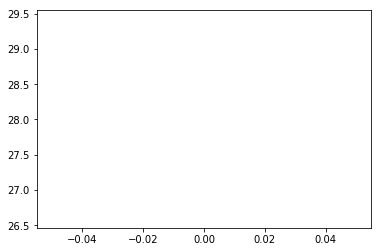

In [14]:
plt.plot(losses['total'])

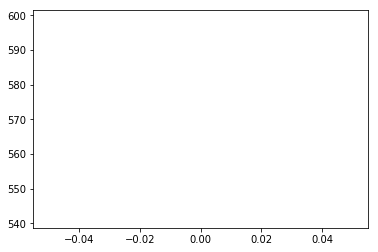

In [15]:
plt.plot(losses['loc'])

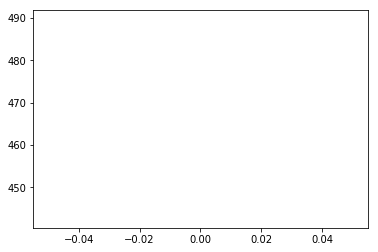

In [16]:
plt.plot(losses['conf'])

## plotting

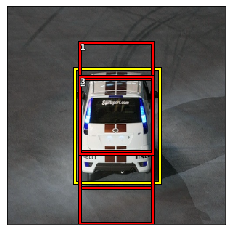

In [17]:
idx = 0
dataset = train_dataset

plot_anchor_bbs(dataset, image_ids, idx, gt_cats)

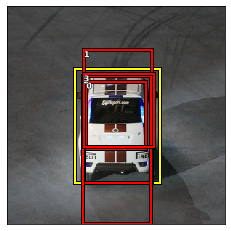

In [18]:
plot_preds(dataset, image_ids, idx, bbs_preds, gt_cats)

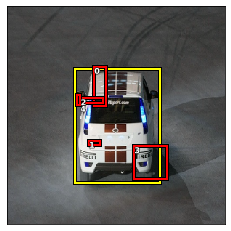

In [19]:
plot_nms_preds(dataset, image_ids, idx, preds, limit=5)